### Map in RGB color

In [1]:
import pandas as pd
import pycountry
import geopandas as gpd
import numpy as np
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

def get_color(color_rgb):
    (r,g,b) = color_rgb
    if not math.isnan(r):
        return mpl.colors.rgb2hex(color_rgb)
    else:
        return np.nan

def create_map_RGB(fname, map_fname, img_title=''):
    regDF = pd.read_csv(fname)
    # Match the Twitter Country Code(iso_a2) againts GeoPandas CC (iso_a3)
    countries = []
    for cc  in regDF['country']:
        iso_a3 = pycountry.countries.get(alpha_2=cc)
        if  iso_a3 is None:
            print("Error: no translation to iso_a3, country code : " , cc)
            regDF.drop(regDF[regDF['country'] == cc].index, inplace=True)
            continue
        countries.append(iso_a3.alpha_3)

    regDF.set_axis(countries, axis="index", inplace=True)
    regDF['iso_a3'] = countries

    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    world = world[(world.pop_est>0) & (world.name!="Antarctica")]

    # Fixing the error in country's name that comes from Geopandas
    world.loc[world['name'] == 'France', ['iso_a3']] = 'FRA'
    world.loc[world['name'] == 'Norway', ['iso_a3']] = 'NOR'
    
    world.set_axis(world['iso_a3'], axis="index", inplace=True)
    world = world.join(regDF, rsuffix='_csv')
    
    world["RGB"] = world[['R','G','B' ]].apply(tuple, axis=1)
    world['color'] = world["RGB"].apply(get_color)
    world.loc[world['color'].isnull(), "RGB"]=np.nan

    c_df = pd.DataFrame(world[world["color"].notnull()]["RGB"])
    colors_1 = c_df.sort_values(by=["RGB"])["RGB"].to_list()
    cmap_name = 'colors_RGB'
    cmap= LinearSegmentedColormap.from_list(cmap_name, colors_1)
    plt.register_cmap(cmap=cmap)
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.set_axis_off()
    ax.set(title=img_title)
    fig.set_facecolor("w")
    world.plot( column="RGB",  ax=ax,  alpha=0.8, legend=False, edgecolor='k', linewidth=0.2,  cmap="colors_RGB",
            missing_kwds={
                "color": "lightgrey",
                #"edgecolor": "red",
                #"hatch": "///",
                #"label": "Missing values",
            },
    )
    fig.savefig(map_fname, bbox_inches = 'tight', dpi=300)
    print("figure created: ", map_fname )

## Building the map in RGB color

Error: no translation to iso_a3, country code :  ALL
figure created:  fig-colormap-common-voc-semantic-4png


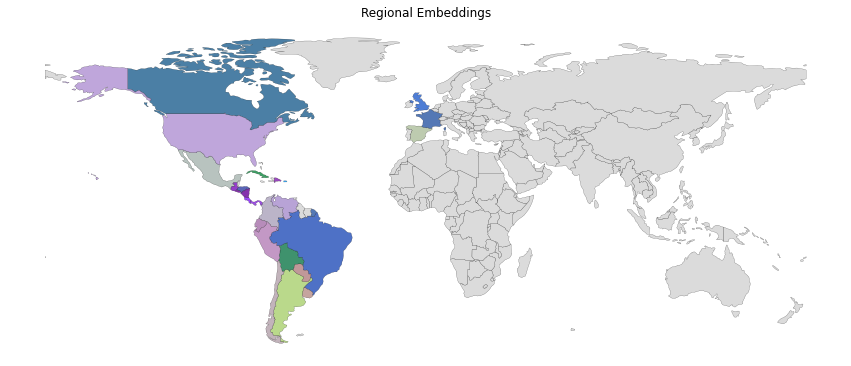

In [2]:
img_title = 'Regional Embeddings'
fname = "colormap-common-voc-semantic-4.csv"
#fname = "region-emo-colors-clustering-umap-12.json"
map_fname = "fig-" + fname[:-4] + "png"
create_map_RGB(fname, map_fname, img_title)